# Model

In [1]:
%load_ext autoreload
%autoreload 2

import os

In [2]:
path_list = os.getcwd().split('\\')
if path_list[-1] == 'src':
    print(os.getcwd())
else:
    os.chdir('..')
    print(os.getcwd())

F:\study\Hackatons\DashboardSber\src


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
pd.set_option('display.max_columns', None)

from prophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

F:\study\Hackatons\DashboardSber\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Загрузка данных

In [4]:
def fix_date_columns(df):
    new_columns = [df.columns[0]]
    for column in df.columns[1:]:
        date = datetime.fromordinal(datetime(1900, 1, 1).toordinal() + int(column) - 2).strftime('%Y-%m-%d')
        new_columns.append(date)

    df.columns = new_columns
    return df


df_acquiring = pd.read_excel(
    io='dataset/acquiring.xlsb',
    engine='pyxlsb',
    header=1,  # У файла есть заголовок-объединение
    # nrows=1000,
)
df_acquiring = fix_date_columns(df_acquiring)

# df_rko = pd.read_excel(
#     io='dataset/rko.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )
# df_rko = fix_date_columns(df_rko)

# df_economy_acquiring = pd.read_excel(
#     io='dataset/economy_acquiring.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )

# df_economy_general = pd.read_excel(
#     io='dataset/economy_general.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )

# df_general = pd.read_excel(
#     io='dataset/general.xlsb',
#     engine='pyxlsb',
#     header=0,  # У файла есть заголовок-объединение
# )
# df_general['Кластер'] = df_general['Кластер'].astype('category')

# Модели

In [5]:
# Про prophet:
# https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet

In [ ]:
# Много моделей prophet с features:
# https://forecastegy.com/posts/multiple-time-series-forecasting-with-prophet-in-python/

In [19]:
TRAIN_END = -5

series_cols = df_acquiring.columns[df_acquiring.columns.str.contains("клиент")==False].values
level_cols = df_acquiring.columns[df_acquiring.columns.str.contains("клиент")].values

In [20]:
timeseries = df_acquiring[series_cols].sum().values
len(timeseries)

24

In [21]:
train_timeseries = timeseries[0:TRAIN_END]
eval_timeseries = timeseries[TRAIN_END::]
print(len(train_timeseries), len(eval_timeseries))

days = np.arange(1, len(series_cols)+1)

19 5


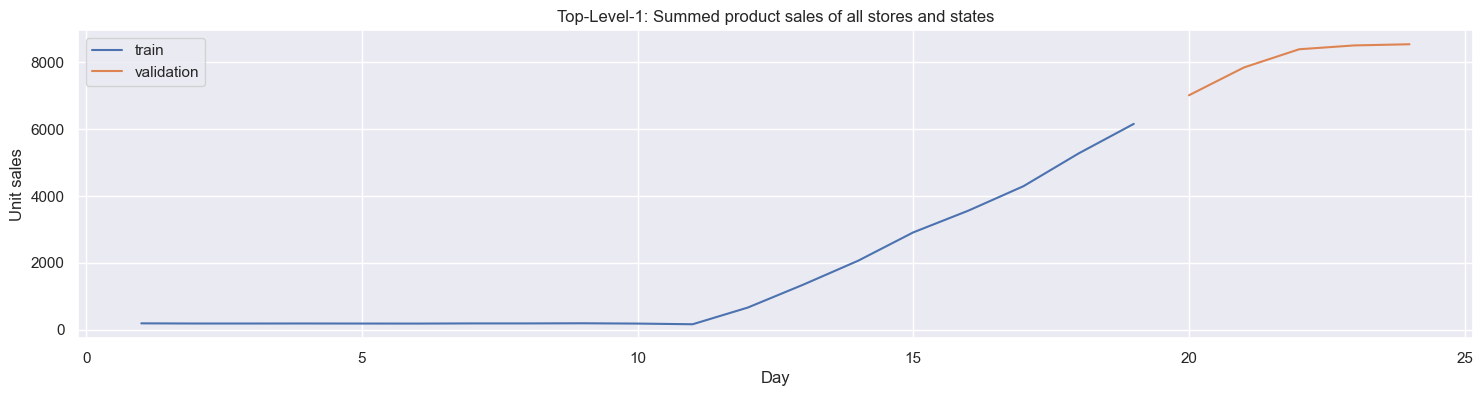

In [22]:
plt.figure(figsize=(18, 4))
plt.plot(days[0:TRAIN_END], train_timeseries, label="train")
plt.plot(days[TRAIN_END::], eval_timeseries, label="validation")
plt.title("Top-Level-1: Summed product sales of all stores and states");
plt.legend()
plt.xlabel("Day")
plt.ylabel("Unit sales");

In [23]:
# dates = calendar.iloc[0:len(timeseries)].date.values
df = pd.DataFrame(series_cols, columns=["ds"])
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
df.loc[:, "y"] = timeseries
df.head()

,ds,y
0,2021-10-31,186
1,2021-11-30,181
2,2021-12-31,181
3,2022-01-31,182
4,2022-02-28,180


In [24]:
train_df = df.iloc[0:TRAIN_END]
print(train_df.shape)

eval_df = df.iloc[TRAIN_END::]
print(eval_df.shape)

(19, 2)
(5, 2)


In [41]:
m = Prophet()
m.fit(train_df)
future = m.make_future_dataframe(periods=abs(TRAIN_END), freq='M')
forecast = m.predict(future)
forecast.head()

12:17:35 - cmdstanpy - INFO - Chain [1] start processing
12:17:52 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-10-31,-2812.188450,185.932209,185.932209,-2812.188450,-2812.188450,2998.120659,2998.120659,2998.120659,2998.120659,2998.120659,2998.120659,0.0,0.0,0.0,185.932209
1,2021-11-30,-2532.914044,181.004919,181.004919,-2532.914044,-2532.914044,2713.918963,2713.918963,2713.918963,2713.918963,2713.918963,2713.918963,0.0,0.0,0.0,181.004919
2,2021-12-31,-2244.331114,181.029005,181.029005,-2244.331114,-2244.331114,2425.360119,2425.360119,2425.360119,2425.360119,2425.360119,2425.360119,0.0,0.0,0.0,181.029005
3,2022-01-31,-1955.744435,181.936747,181.936747,-1955.744435,-1955.744435,2137.681182,2137.681182,2137.681182,2137.681182,2137.681182,2137.681182,0.0,0.0,0.0,181.936747
4,2022-02-28,-1695.086207,180.041024,180.041024,-1695.086207,-1695.086207,1875.127231,1875.127231,1875.127231,1875.127231,1875.127231,1875.127231,0.0,0.0,0.0,180.041024


In [42]:
col_int = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
forecast[col_int].head()

,ds,yhat,yhat_lower,yhat_upper
0,2021-10-31,185.932209,185.932209,185.932209
1,2021-11-30,181.004919,181.004919,181.004919
2,2021-12-31,181.029005,181.029005,181.029005
3,2022-01-31,181.936747,181.936747,181.936747
4,2022-02-28,180.041024,180.041024,180.041024


F:\study\Hackatons\DashboardSber\venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
F:\study\Hackatons\DashboardSber\venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


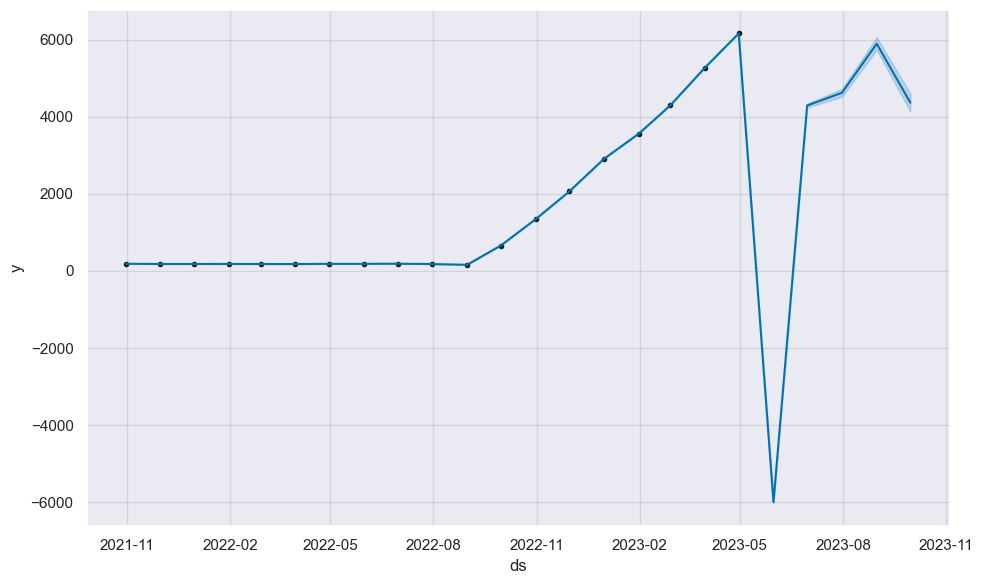

In [43]:
m.plot(forecast);

F:\study\Hackatons\DashboardSber\venv\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
F:\study\Hackatons\DashboardSber\venv\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
F:\study\Hackatons\DashboardSber\venv\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarra

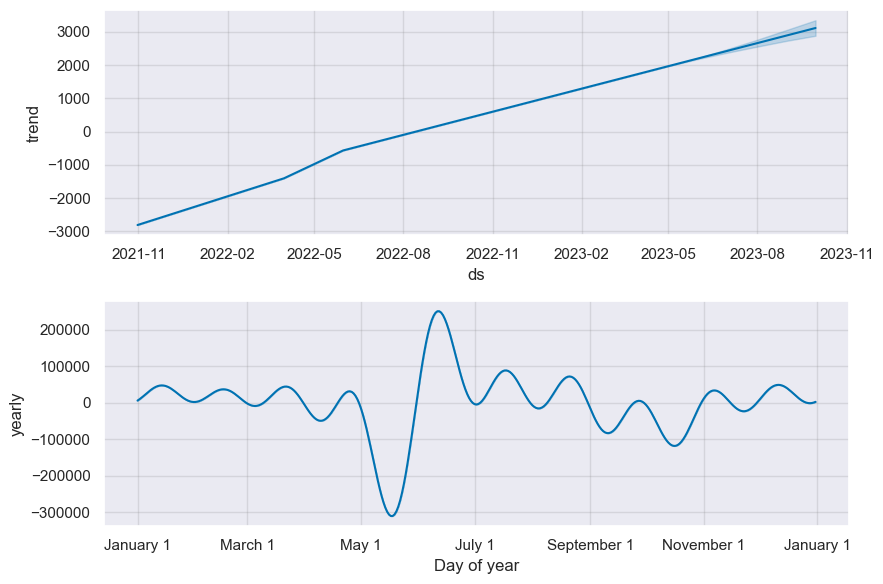

In [44]:
m.plot_components(forecast);

In [46]:
df_acquiring.iloc[:, 2].sum()

181

In [47]:
df_acquiring.iloc[:, 1].sum()

186

In [45]:
((df_acquiring.iloc[:, 2].sum() - df_acquiring.iloc[:, 1].sum()) / df_acquiring.iloc[:, 1].sum()) * 100

-2.6881720430107525

In [ ]:
# Calculate root mean squared error.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1682, 'yhat']-transactions['y'])**2)) )

### Расчёт показателя
#### ((df_acquiring.iloc[:, 2].sum() - df_acquiring.iloc[:, 1].sum()) / df_acquiring.iloc[:, 1].sum()) * 100